In [1]:
%matplotlib ipympl

In [2]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

# hostname = os.uname()
# if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')


In [3]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [4]:
DataPath = os.path.abspath('../Data/Proccessed/')
print('DataPath:',DataPath)

DataPath: /home/fedor-tairli/work/CDEs/Data/Proccessed


In [5]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1:
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys():
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2')
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2')
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [6]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [7]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [8]:
AllPossiblePixelDirections.head()

EyeID  TelID  PixID    Theta      Phi
0      1      1      1  1.61140  358.419
1      1      1      2  2.86980  359.174
2      1      1      3  4.13764  358.434
3      1      1      4  5.38773  359.205
4      1      1      5  6.66357  358.476

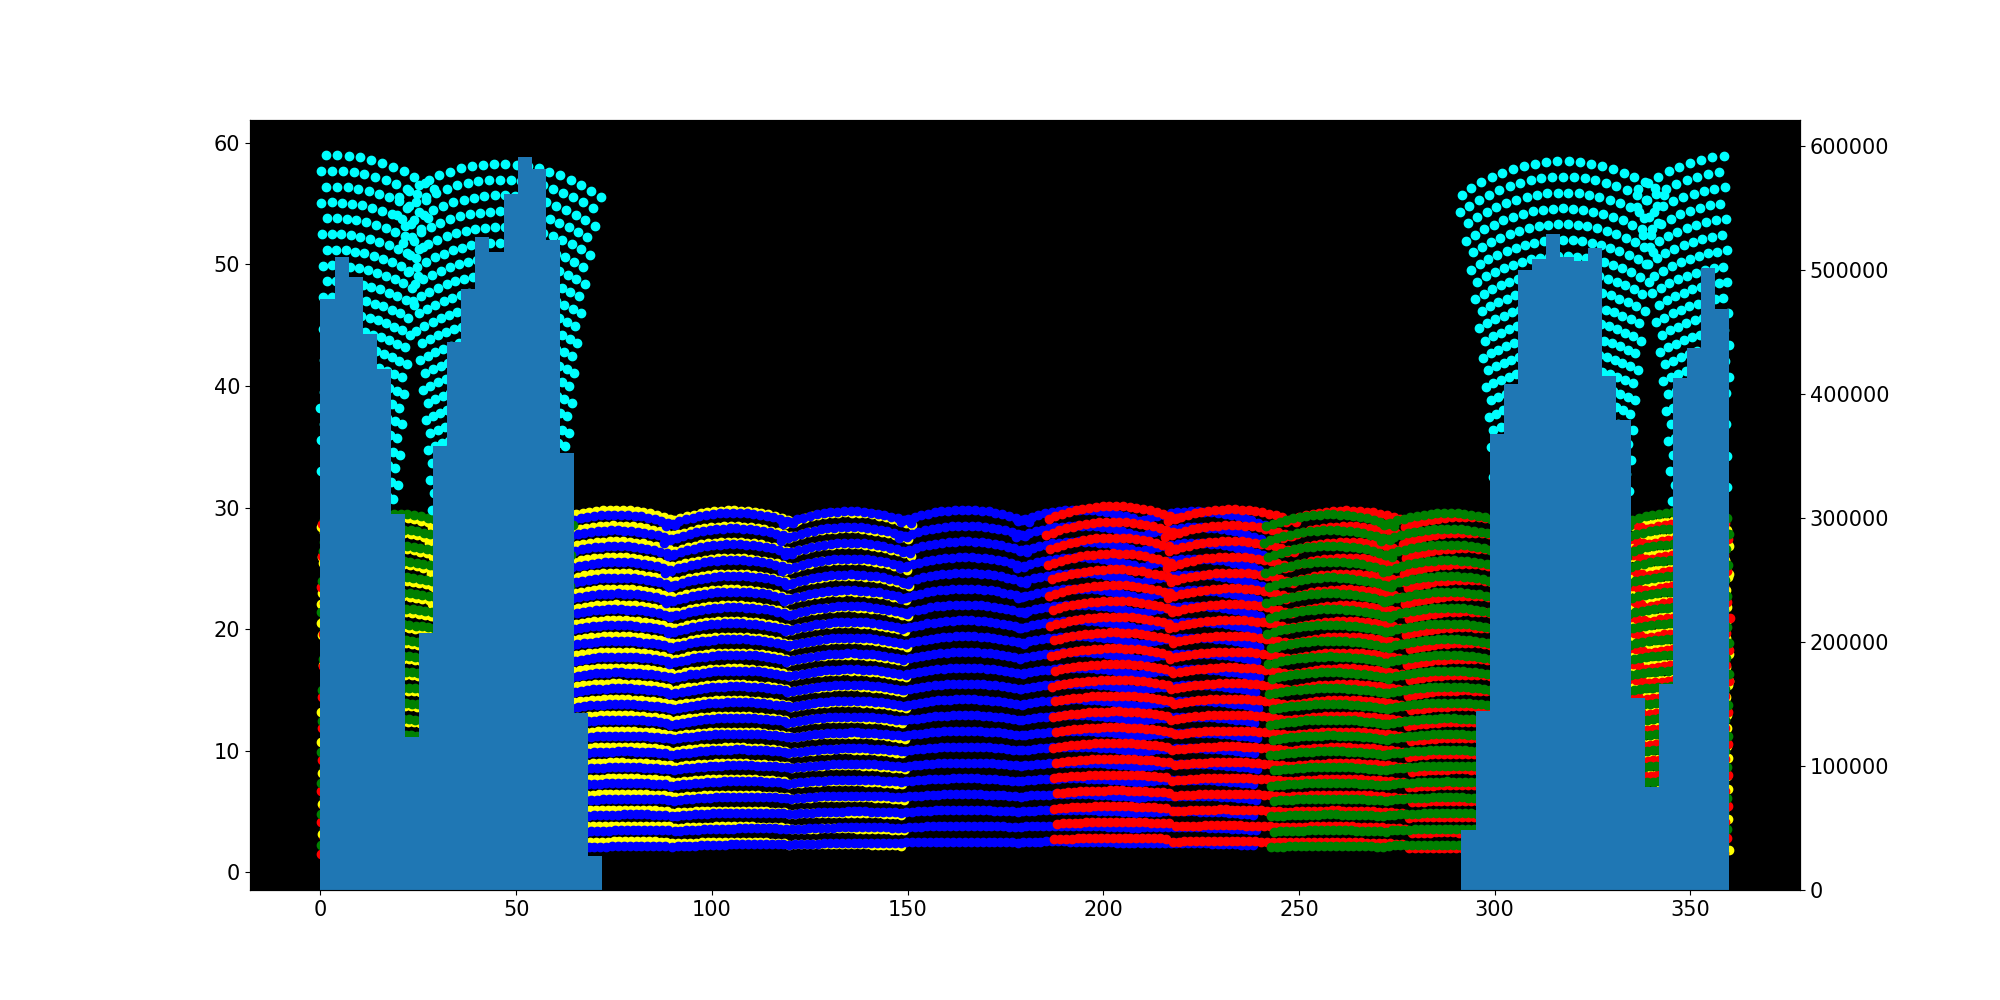

In [9]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = [20,10])
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

#### Full Geometry Normalisation


In [10]:
# Telescope Offsets
HE_1_OA_Phi   = (   44.45)/180*np.pi
HE_1_OA_Theta = (90-45.07)/180*np.pi
HE_2_OA_Phi   = (   89.87)/180*np.pi
HE_2_OA_Theta = (90-45.58)/180*np.pi
HE_3_OA_Phi   = (  132.83)/180*np.pi
HE_3_OA_Theta = (90-44.85)/180*np.pi

HE_OA_Phi   = {1: HE_1_OA_Phi  , 2: HE_2_OA_Phi  , 3: HE_3_OA_Phi  }
HE_OA_Theta = {1: HE_1_OA_Theta, 2: HE_2_OA_Theta, 3: HE_3_OA_Theta}
    

SDPTheta: 81.00076382012281
SDPPhi  : 178.79892990378792
Rp      : 1.1150100231170654
Chi0    : 48.72186695362741
TelID: 2.0


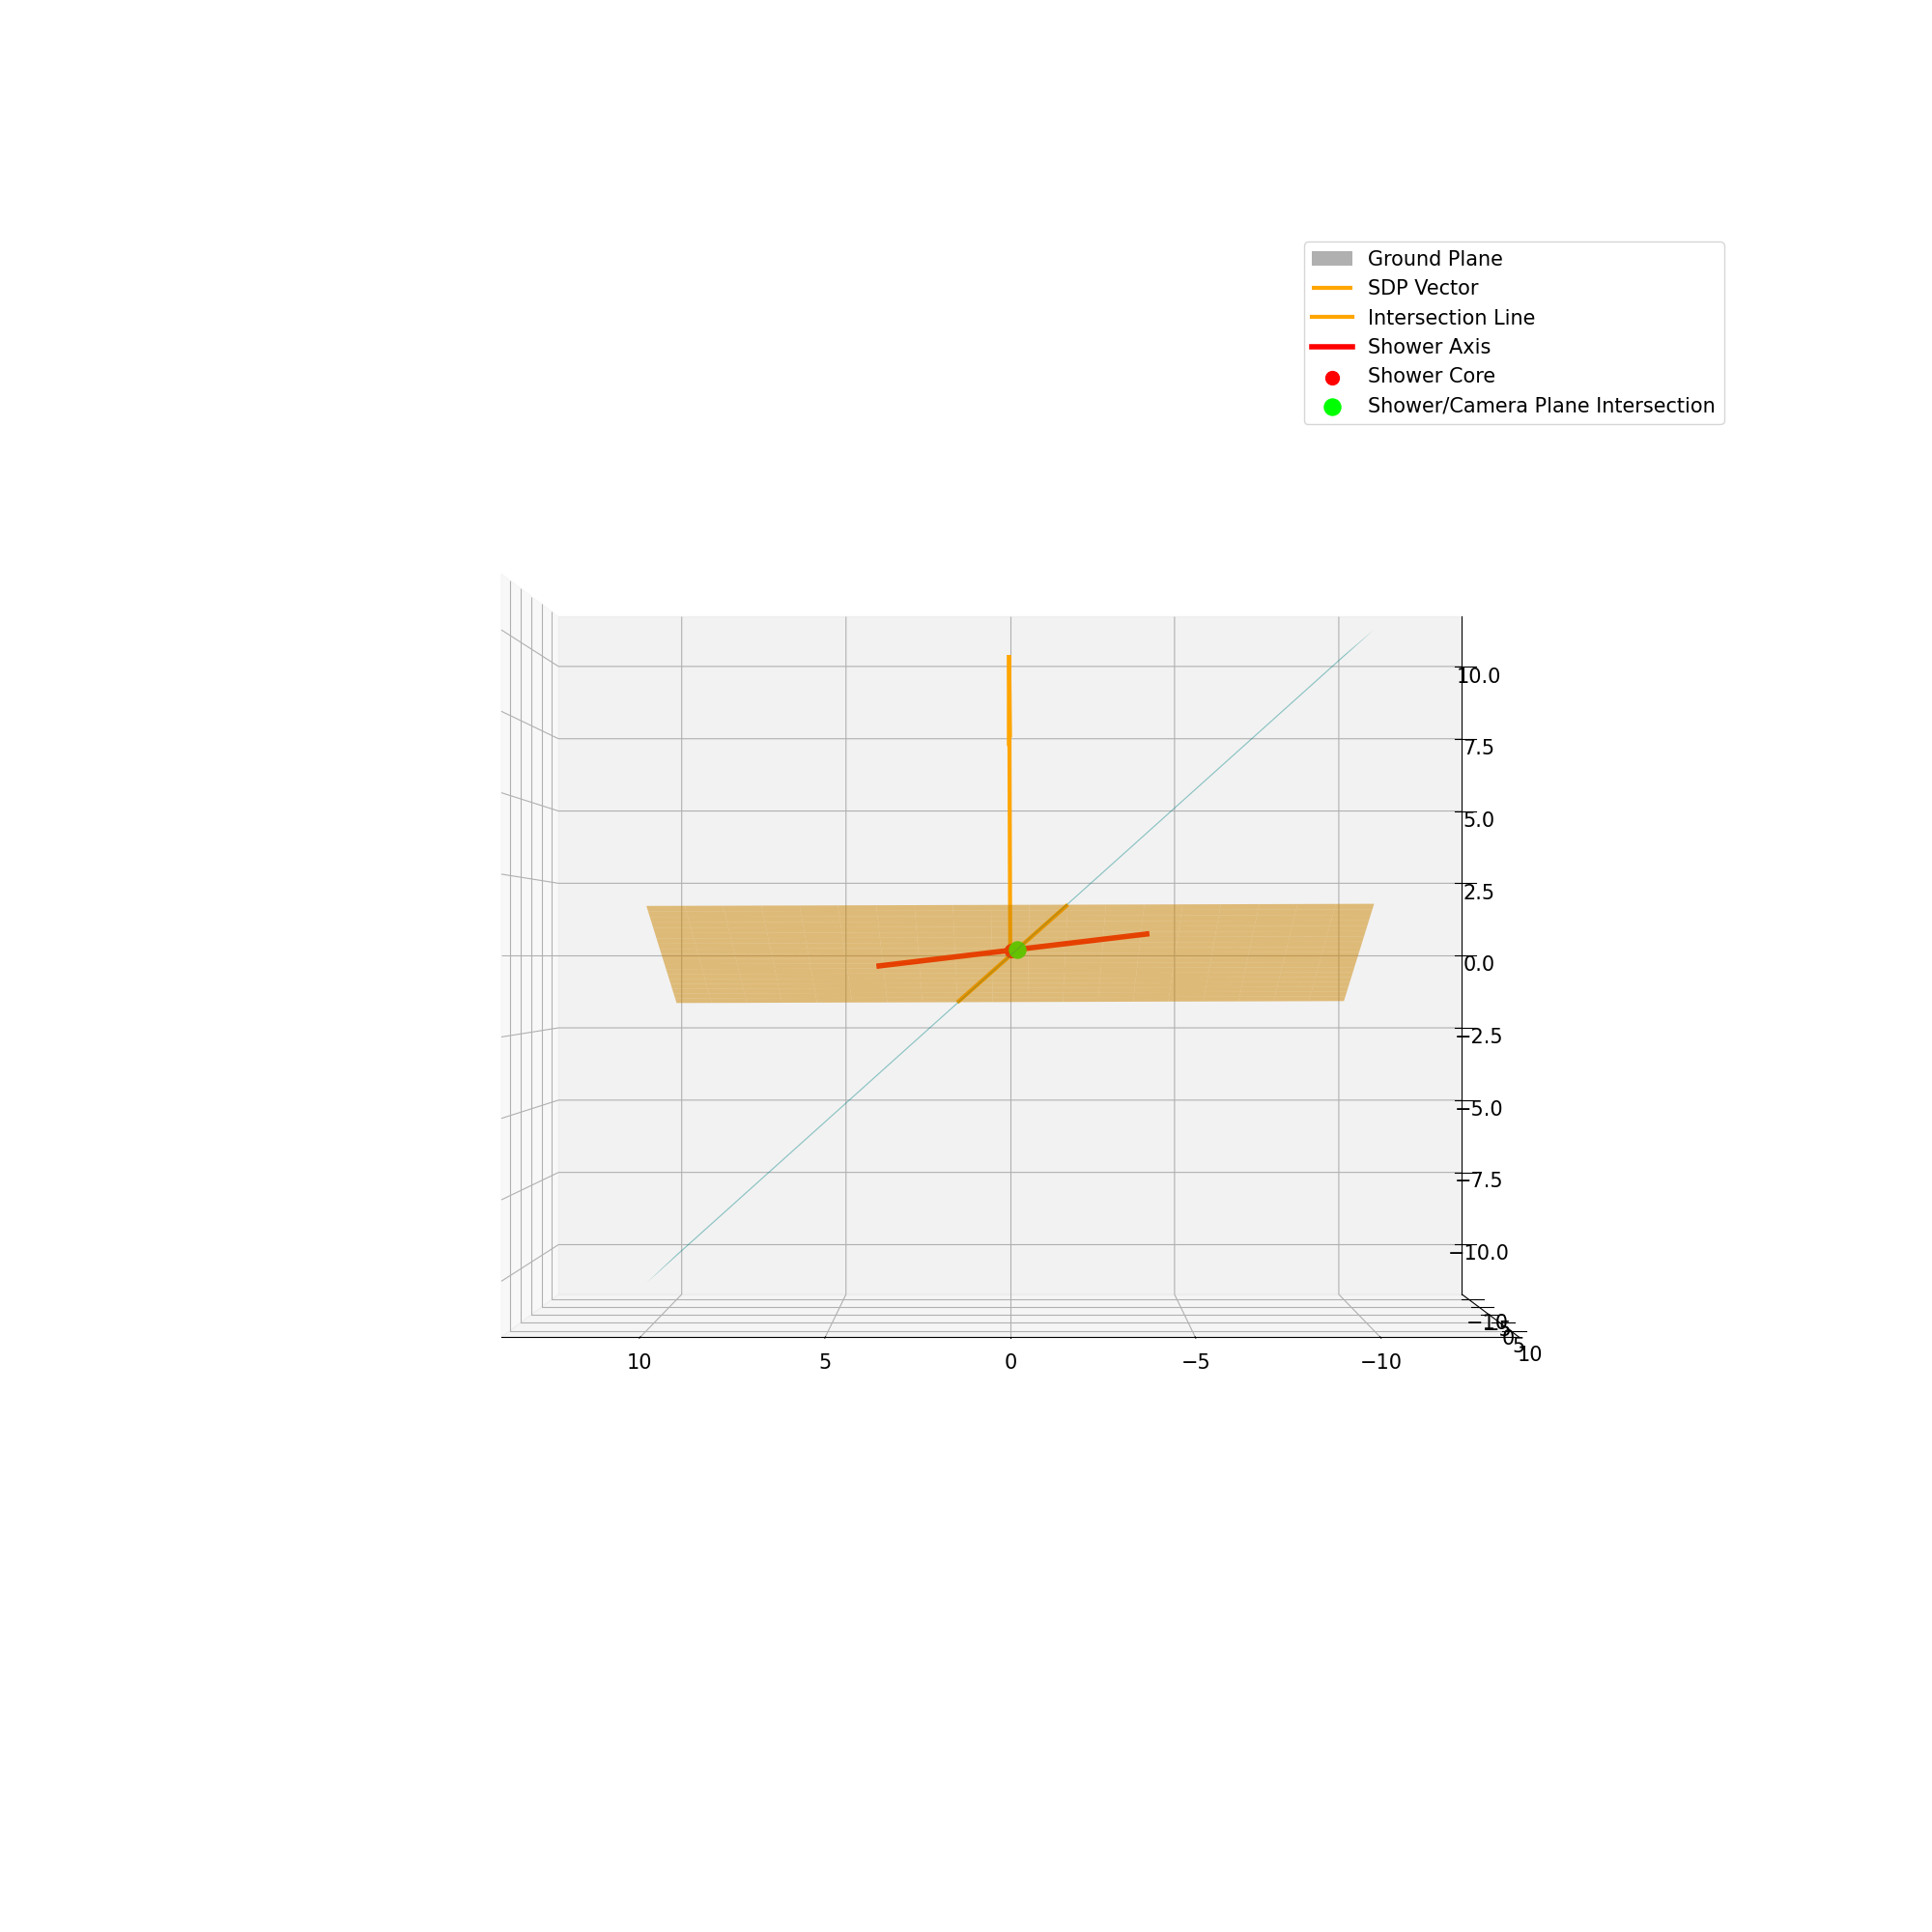

In [11]:
# Get a random event

TelID = 0
while TelID != 2:
    randomN = np.random.randint(0,len(Dataset))
    Event = Dataset.get_event_by_index(randomN)

    # Get Gen values
    SDPTheta = Event.get_value('Gen_SDPTheta')
    SDPPhi   = Event.get_value('Gen_SDPPhi')
    Rp       = Event.get_value('Gen_Rp')/1000  # Convert from km to m
    Chi0     = Event.get_value('Gen_Chi0')

    # Select which telescope it is:
    AllTelIDS = Event.get_pixel_values('TelID')
    TelID = AllTelIDS[0].item()  # Assuming all pixels in the event

print('SDPTheta:',SDPTheta.item()*180/np.pi)
print('SDPPhi  :',SDPPhi  .item()*180/np.pi)
print('Rp      :',Rp      .item())
print('Chi0    :',Chi0    .item()*180/np.pi)

print('TelID:',TelID)
# Define the camera plane by the origin at [0,0,0] and normal from the optical axis



fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
plane_size = 10
AboveGroundOnly = False# Find the shower core point at distance Rp from the origin in the SDP plane

###########################################
# Plot the ground plane
###########################################

nx = 0
ny = 0
nz = 1
GroundNormal = np.array([nx, ny, nz])
xx, yy = np.meshgrid(np.linspace(-plane_size*1.2, plane_size*1.2, 20),
                     np.linspace(-plane_size*1.2, plane_size*1.2, 20))
zz = -(nx * xx + ny * yy) / nz

ax.plot_surface(xx, yy, zz, alpha=0.5, color='gray', label='Ground Plane')

###########################################
# Plot the camera plane and the optical axis
###########################################

Tel_OA_Phi   = HE_OA_Phi  [TelID]
Tel_OA_Theta = HE_OA_Theta[TelID]

nx = np.sin(Tel_OA_Phi) * np.cos(Tel_OA_Theta)
ny = np.cos(Tel_OA_Phi) * np.cos(Tel_OA_Theta)
nz = np.sin(Tel_OA_Theta)
CameraNormal = np.array([nx,ny,nz])

xx, yy = np.meshgrid(np.linspace(-plane_size, plane_size, 20),
                     np.linspace(-plane_size, plane_size, 20))
zz = -(nx * xx + ny * yy) / nz
if AboveGroundOnly: zz = np.where(zz < 0, np.nan, zz) # Mask below ground plane

ax.plot_surface(xx, yy, zz, alpha=0.5, color='cyan')
# ax.quiver(0, 0, 0, nx, ny, nz, length=plane_size, color='blue', linewidth=3, label='Optical Axis')

# ##############################################
# # Plot the SDP
# ##############################################

nx = np.sin(SDPPhi) * np.cos(SDPTheta)
ny = np.cos(SDPPhi) * np.cos(SDPTheta)
nz = np.sin(SDPTheta)
SDPVector = np.array([nx, ny, nz])

xx, yy = np.meshgrid(np.linspace(-plane_size, plane_size, 20),
                     np.linspace(-plane_size, plane_size, 20))
zz = -(nx * xx + ny * yy) / nz
if AboveGroundOnly: zz = np.where(zz < 0, np.nan, zz) # Mask below ground plane
ax.plot_surface(xx, yy, zz, alpha=0.5, color='orange')
ax.quiver(0, 0, 0, nx, ny, nz, length=plane_size, color='orange', linewidth=3, label='SDP Vector')



# ##############################################
# # Plot the intersection of the SDP and the camera plane
# ##############################################

# Calculate intersection line direction (cross product of normals)
intersection_dir = np.cross(CameraNormal, SDPVector)
intersection_dir = intersection_dir / np.linalg.norm(intersection_dir)  # normalize

# Choose a point on the intersection line (origin is fine)
point_on_line = np.array([0, 0, 0])

# Create points along the intersection line for plotting
t = np.linspace(-plane_size, plane_size, 100)
line_points = point_on_line[:, None] + intersection_dir[:, None] * t

# Plot the intersection line
ax.plot(line_points[0], line_points[1], line_points[2], color='orange', linewidth=3, label='Intersection Line')

# ##############################################
# # Plot the shower axis
# ##############################################

# Find the shower axis direction
in_SDP_ground = np.cross(SDPVector, np.cross(GroundNormal, SDPVector))
in_SDP_ground = in_SDP_ground / np.linalg.norm(in_SDP_ground)

in_SDP_perp = np.cross(SDPVector, in_SDP_ground)
in_SDP_perp = in_SDP_perp / np.linalg.norm(in_SDP_perp)

ShowerAxis = np.cos(Chi0) * in_SDP_ground + np.sin(Chi0) * in_SDP_perp
ShowerAxis = ShowerAxis / np.linalg.norm(ShowerAxis)

# Find a point in space using the Rp value

# Find the shower core point at distance Rp from the origin in the SDP plane
shower_core = Rp * in_SDP_ground  # This is a point on the SDP plane

# Now you can plot the shower axis as a line through this point in the ShowerAxis direction
shower_length = plane_size  # or any length you want for visualization
shower_line = np.array([
    shower_core - ShowerAxis * shower_length / 2,
    shower_core + ShowerAxis * shower_length / 2
])

ax.plot(shower_line[:,0], shower_line[:,1], shower_line[:,2], color='red', linewidth=4, label='Shower Axis')
ax.scatter(*shower_core, color='red', s=100, label='Shower Core')


A = np.column_stack((ShowerAxis, -intersection_dir))  # shape (3,2)
b = -shower_core

# Least squares solution
t_sol, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
t1, t2 = t_sol

# Intersection point on shower axis
intersection_point = shower_core + ShowerAxis * t1

# Plot this point
ax.scatter(*intersection_point, color='lime', s=150, label='Shower/Camera Plane Intersection')
ax.legend()

# Setup viewing angle in the direction along the camera plane
ax.view_init(elev=0, azim=90)

In [12]:
# Find the Shower Core and Axis


def GetShowerGeometry_CameraPlane(SDPTheta,SDPPhi,Chi0,Rp,Camera_OA_Theta,Camera_OA_Phi):
    # Firs calculate the Shower Axis

    # SDP Vector in 3D space
    SDPVector = np.array([
        np.sin(SDPPhi) * np.cos(SDPTheta),
        np.cos(SDPPhi) * np.cos(SDPTheta),
        np.sin(SDPTheta)
    ])
    SDPVector /= np.linalg.norm(SDPVector)
    
    # Find the shower axis direction
    GroundNormal = np.array([0, 0, 1])  # Ground plane normal
    Ground_in_SDP = np.cross(SDPVector, np.cross(GroundNormal, SDPVector))
    Ground_in_SDP /= np.linalg.norm(Ground_in_SDP)

    GroundPerp_In_SDP = np.cross(SDPVector, Ground_in_SDP)
    GroundPerp_In_SDP /= np.linalg.norm(GroundPerp_In_SDP)

    ShowerAxis_dir = np.cos(Chi0) * Ground_in_SDP + np.sin(Chi0) * GroundPerp_In_SDP
    ShowerAxis_dir /= np.linalg.norm(ShowerAxis_dir)


    # Find the Shower axis point where the shower axis is closest to FD
    ShowerPerp_dir = np.cross(SDPVector, ShowerAxis_dir)
    ShowerPerp_dir /= np.linalg.norm(ShowerPerp_dir)
    ShowerPerpPoint = - Rp * ShowerPerp_dir # This is a point on the SDP plane at distance Rp from the origin perpendicular to the shower axis vector

    # Find the intersection of the shower axis with the camera plane
    Camera_OA_Vector = np.array([
        np.sin(Camera_OA_Phi) * np.cos(Camera_OA_Theta),
        np.cos(Camera_OA_Phi) * np.cos(Camera_OA_Theta),
        np.sin(Camera_OA_Theta)
    ])
    Camera_OA_Vector /= np.linalg.norm(Camera_OA_Vector)

    # Find intersection point of the shower axis with the camera plane
    # P = ShowerPerpPoint + t * ShowerAxis_dir
    # Camera_OA_Vector · P = 0 (becasue camera is at origin)

    # Solve for t

    t_intersect = -np.dot(Camera_OA_Vector, ShowerPerpPoint) / np.dot(Camera_OA_Vector, ShowerAxis_dir)
    intersection_point = ShowerPerpPoint + t_intersect * ShowerAxis_dir

    # Renormalise the Shower Axis to be in the camera plane representation

    Z_cam = Camera_OA_Vector

    Global_Up = np.array([0, 0, 1])  # Global up vector
    X_cam = Global_Up - np.dot(Global_Up, Z_cam) * Z_cam  # Project Global Up onto the camera plane
    X_cam /= np.linalg.norm(X_cam)  # Norm is never gonna be zero, camera is not facing up
    Y_cam = np.cross(Z_cam, X_cam)  # Y is orthogonal to both Z and X
    Y_cam /= np.linalg.norm(Y_cam)  # Normalize Y
    

    # Shower Axis in camera plane coordinates
    shower_axis_cam = np.array([
        np.dot(ShowerAxis_dir, X_cam),
        np.dot(ShowerAxis_dir, Y_cam),
        np.dot(ShowerAxis_dir, Z_cam)
    ])

    Axis_Zenith    = np.arccos(shower_axis_cam[2])  # in radians
    Axis_Azimuth   = np.arctan2(shower_axis_cam[1], shower_axis_cam[0])  # in radians

    X_Intersection = np.dot(intersection_point, X_cam)
    Y_Intersection = np.dot(intersection_point, Y_cam)
    Z_Intersection = np.dot(intersection_point, Z_cam)  # Should be ~0 if it's in the plane


    return Axis_Zenith, Axis_Azimuth, X_Intersection, Y_Intersection, Z_Intersection


# TestOut the function
print(f'SDPTheta: {SDPTheta.item()*180/np.pi:.4g}, SDPPhi: {SDPPhi.item()*180/np.pi:.4g}, Chi0: {Chi0.item()*180/np.pi:.4g}, Rp: {Rp.item():.4g}')
Axis_Zenith, Axis_Azimuth, X_Intersection, Y_Intersection, Z_Intersection = GetShowerGeometry_CameraPlane(
    SDPTheta.item(),
    SDPPhi.item(),
    Chi0.item(),
    Rp.item(),
    Tel_OA_Theta,
    Tel_OA_Phi
)

print(f'Axis_Zenith: {Axis_Zenith*180/np.pi:.4g}, Axis_Azimuth: {Axis_Azimuth*180/np.pi:.4g}, X_Intersection: {X_Intersection:.4g}, Y_Intersection: {Y_Intersection:.4g}, Z_Intersection: {Z_Intersection:.4g}')

SDPTheta: 81, SDPPhi: 178.8, Chi0: 48.72, Rp: 1.115
Axis_Zenith: 118.2, Axis_Azimuth: -46.35, X_Intersection: 0.3686, Y_Intersection: -1.658, Z_Intersection: 0


Text(0.5, 0, 'Z')

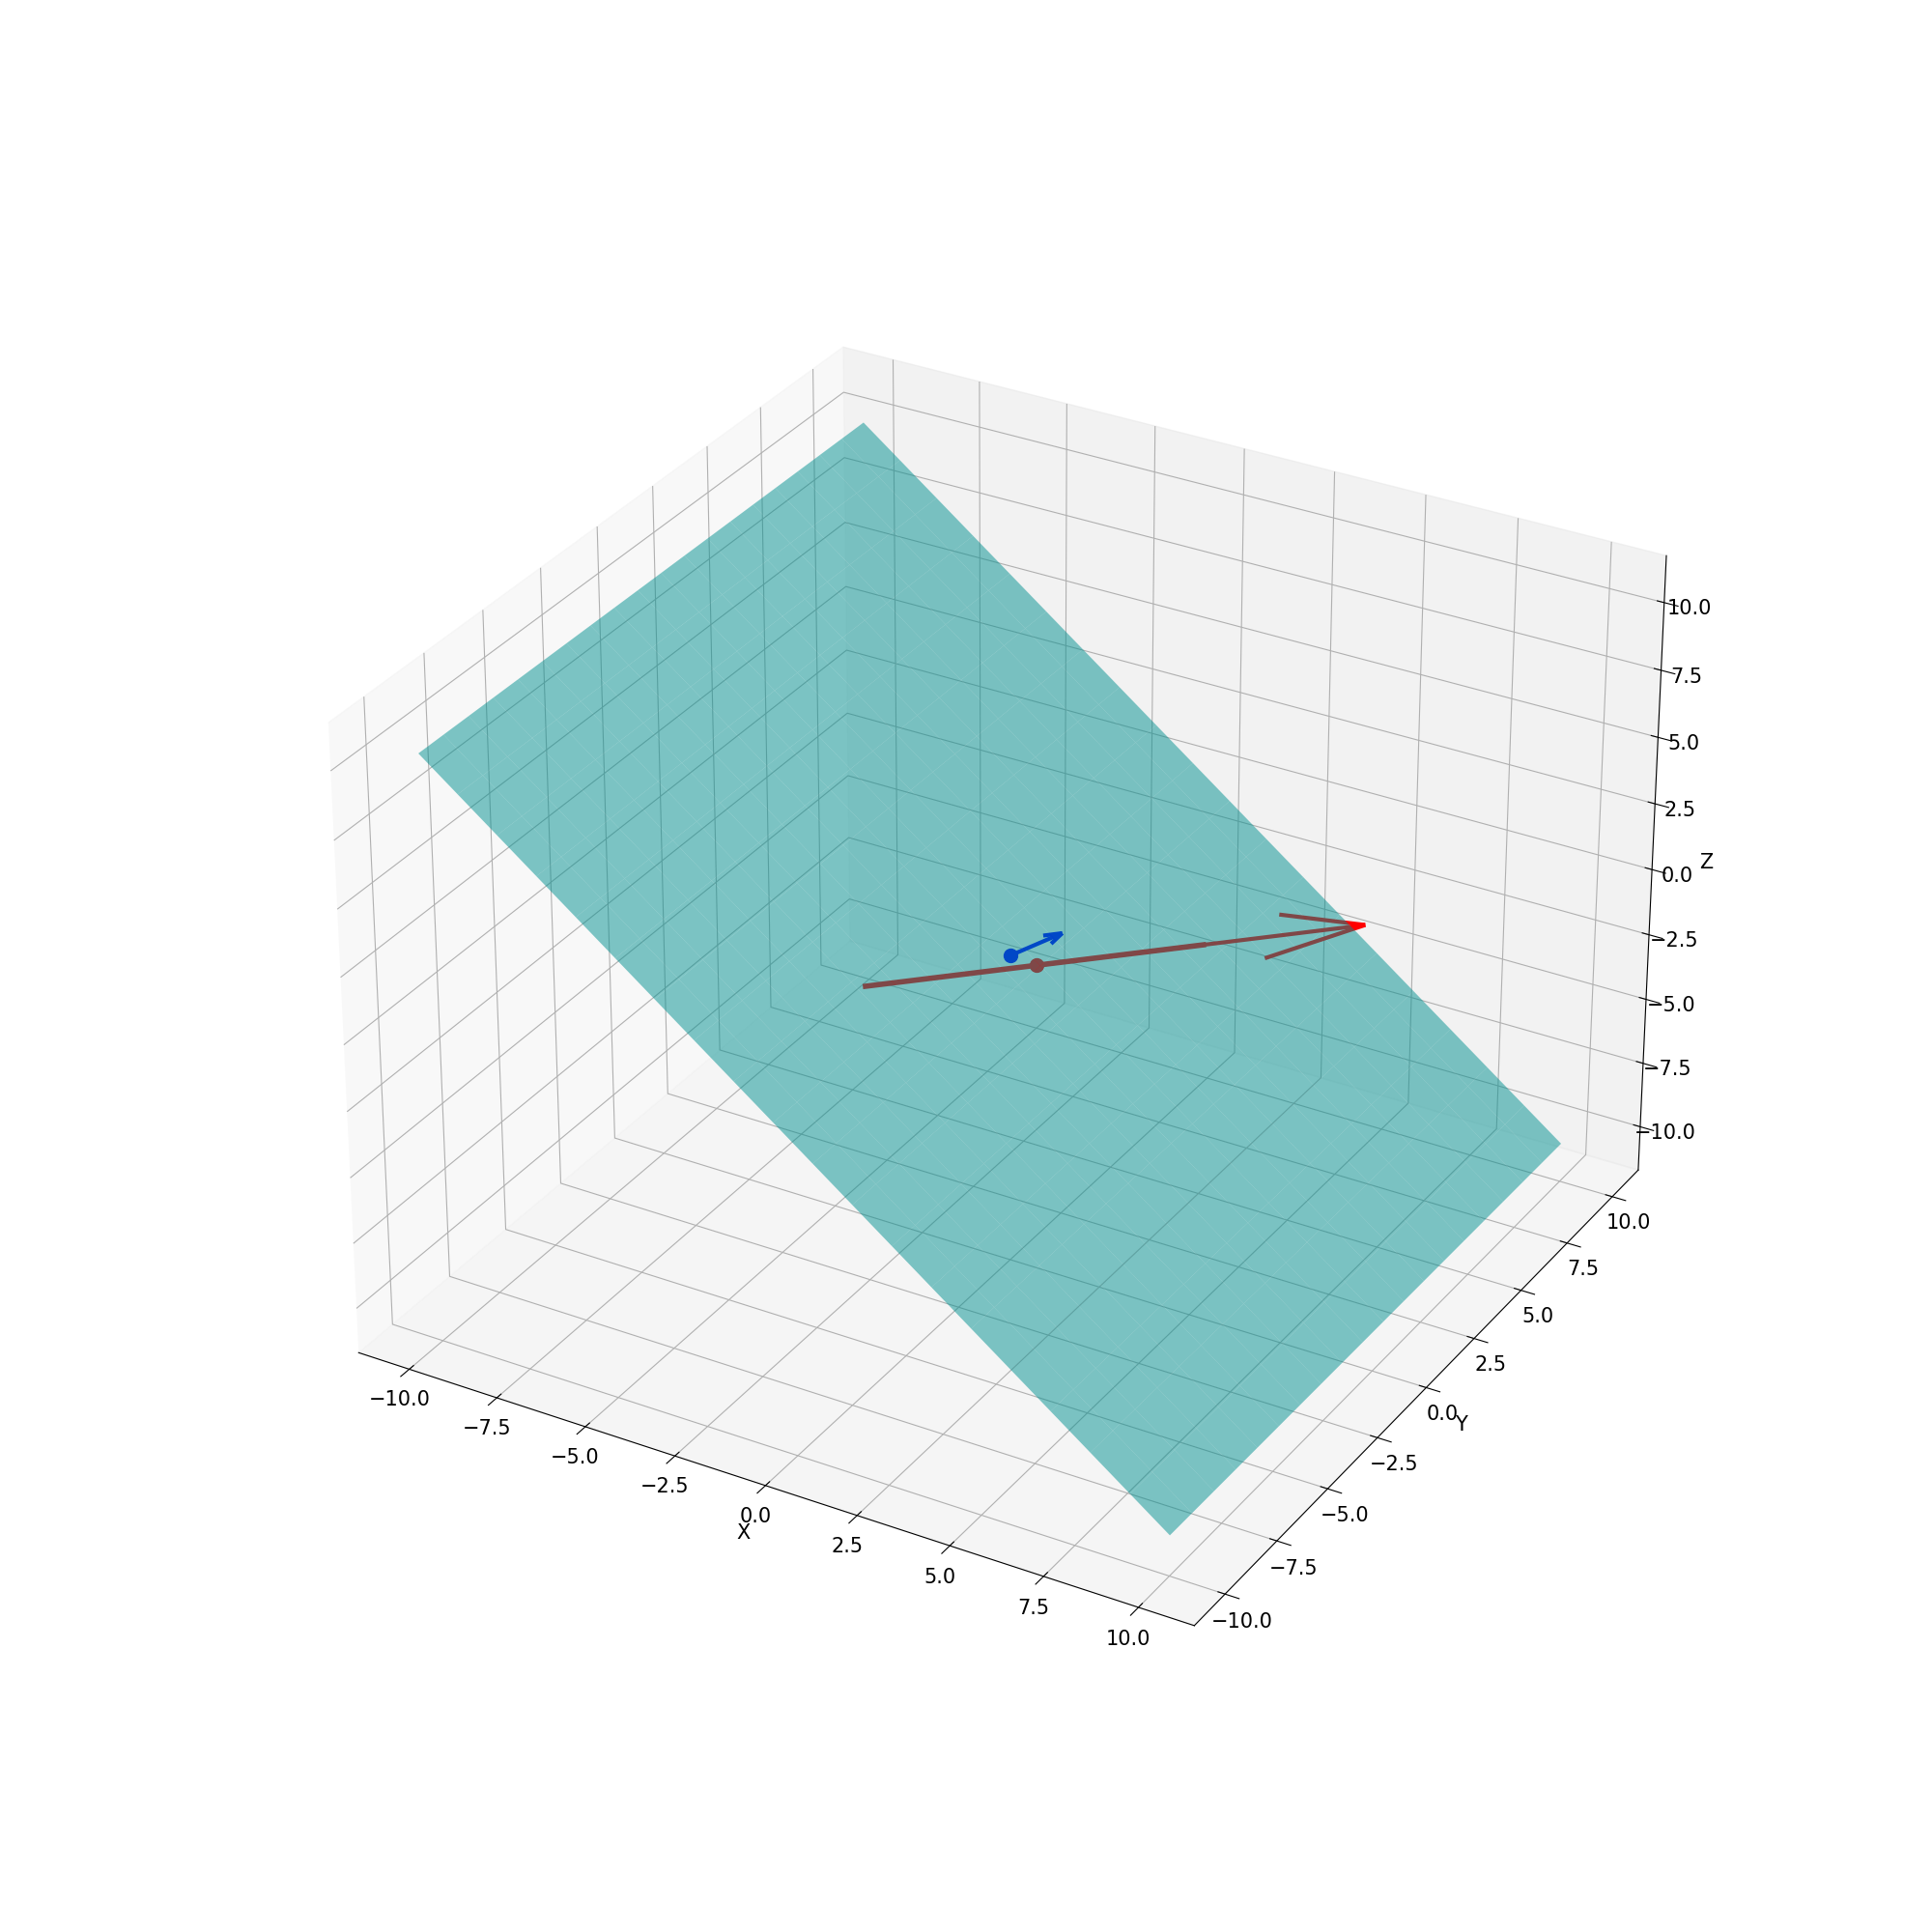

In [13]:
# Now we test the thing by Plotting Both the Shower Axis in the Default Coordinates and the Camera Coordinates
# Get a random event

TelID = 0
while TelID not in [2,]:
    randomN = np.random.randint(0,len(Dataset))
    Event = Dataset.get_event_by_index(randomN)

    # Get Gen values
    SDPTheta = Event.get_value('Gen_SDPTheta')
    SDPPhi   = Event.get_value('Gen_SDPPhi')
    Rp       = Event.get_value('Gen_Rp')/1000  # Convert from km to m
    Chi0     = Event.get_value('Gen_Chi0')

    # Select which telescope it is:
    AllTelIDS = Event.get_pixel_values('TelID')
    TelID = AllTelIDS[0].item()  # Assuming all pixels in the event

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# Get Axis
SDP_Vector = np.array([
    np.sin(SDPPhi) * np.cos(SDPTheta),
    np.cos(SDPPhi) * np.cos(SDPTheta),
    np.sin(SDPTheta)
])
SDP_Vector /= np.linalg.norm(SDP_Vector)

# Find the shower axis direction
GroundNormal = np.array([0, 0, 1])  # Ground plane normal
Ground_in_SDP = np.cross(SDP_Vector, np.cross(GroundNormal, SDP_Vector))
Ground_in_SDP /= np.linalg.norm(Ground_in_SDP)
GroundPerp_In_SDP = np.cross(SDP_Vector, Ground_in_SDP)
GroundPerp_In_SDP /= np.linalg.norm(GroundPerp_In_SDP)
ShowerAxis_dir = np.cos(Chi0) * Ground_in_SDP + np.sin(Chi0) * GroundPerp_In_SDP
ShowerAxis_dir /= np.linalg.norm(ShowerAxis_dir)

# Find the Shower axis point where the shower axis is closest to FD
ShowerPerp_dir = np.cross(SDP_Vector, ShowerAxis_dir)
ShowerPerp_dir /= np.linalg.norm(ShowerPerp_dir)
ShowerPerpPoint = - Rp * ShowerPerp_dir  # This is a point on the SDP plane at distance Rp from the origin perpendicular to the shower axis vector

# plot the Shower Axis
shower_length = 10  # or any length you want for visualization
shower_line = np.array([
    ShowerPerpPoint - ShowerAxis_dir * shower_length / 2,
    ShowerPerpPoint + ShowerAxis_dir * shower_length / 2
])

ax.plot(shower_line[:,0], shower_line[:,1], shower_line[:,2], color='red', linewidth=4, label='Shower Axis')
ax.scatter(*ShowerPerpPoint, color='red', s=100, label='Shower Core')
ax.quiver(ShowerPerpPoint[0], ShowerPerpPoint[1], ShowerPerpPoint[2],
           ShowerAxis_dir[0], ShowerAxis_dir[1], ShowerAxis_dir[2],
           length=shower_length, color='red', linewidth=3, label='Shower Axis Direction')
# Plot the camera and the OA of the camera
Camera_OA_Vector = np.array([
    np.sin(Tel_OA_Phi) * np.cos(Tel_OA_Theta),
    np.cos(Tel_OA_Phi) * np.cos(Tel_OA_Theta),
    np.sin(Tel_OA_Theta)
])
Camera_OA_Vector /= np.linalg.norm(Camera_OA_Vector)
OA_length = 2  # Length of the OA vector for visualization

ax.quiver(0, 0, 0, Camera_OA_Vector[0], Camera_OA_Vector[1], Camera_OA_Vector[2], length=OA_length, color='blue', linewidth=3, label='Camera OA')
ax.scatter(0,0,0, color='blue', s=100, label='Camera Origin')

# Now Procude the Shower Axis in the Camera Plane Coordinates
Axis_Zenith, Axis_Azimuth, X_Intersection, Y_Intersection, Z_Intersection = GetShowerGeometry_CameraPlane( SDPTheta.item(), SDPPhi.item(), Chi0.item(), Rp.item(), Tel_OA_Theta, Tel_OA_Phi)
    
# Now plot the new shower axis in the camera plane coordinates
plane_size = 10
nx = np.sin(Tel_OA_Phi) * np.cos(Tel_OA_Theta)
ny = np.cos(Tel_OA_Phi) * np.cos(Tel_OA_Theta)
nz = np.sin(Tel_OA_Theta)
CameraNormal = np.array([nx,ny,nz])

xx, yy = np.meshgrid(np.linspace(-plane_size, plane_size, 20),
                     np.linspace(-plane_size, plane_size, 20))
zz = -(nx * xx + ny * yy) / nz
if AboveGroundOnly: zz = np.where(zz < 0, np.nan, zz) # Mask below ground plane

ax.plot_surface(xx, yy, zz, alpha=0.5, color='cyan')


# Find the intersection point in the camera plane converted to normal coordinates
Intersection_Cam = np.array([X_Intersection,Y_Intersection,Z_Intersection])




ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [14]:
All_SDP_Thetas = []
All_SDP_Phis   = []
ALL_Chi0s      = []
All_Rps        = []

All_Axis_Zeniths    = []
All_Axis_Azimuths   = []
All_X_Intersections = []
All_Y_Intersections = []
All_Z_Intersections = []

All_Tel_IDs = []

NEvents = 100000

for i, Event in enumerate(Dataset):
    # Get Gen values
    SDPTheta = Event.get_value('Gen_SDPTheta')
    SDPPhi   = Event.get_value('Gen_SDPPhi')
    Rp       = Event.get_value('Gen_Rp')/1000  # Convert from km to m
    Chi0     = Event.get_value('Gen_Chi0')

    # Select which telescope it is:
    AllTelIDS = Event.get_pixel_values('TelID')
    TelID = AllTelIDS[0].item()  # Assuming all pixels in the event

    Tel_OA_Phi   = HE_OA_Phi  [TelID]
    Tel_OA_Theta = HE_OA_Theta[TelID]

    Axis_Zenith, Axis_Azimuth, X_Intersection, Y_Intersection, Z_Intersection = GetShowerGeometry_CameraPlane(
        SDPTheta.item(),
        SDPPhi.item(),
        Chi0.item(),
        Rp.item(),
        Tel_OA_Theta,
        Tel_OA_Phi
    )

    All_SDP_Thetas.append(SDPTheta.item())
    All_SDP_Phis  .append(SDPPhi.item())
    ALL_Chi0s     .append(Chi0.item())
    All_Rps       .append(Rp.item())

    All_Axis_Zeniths   .append(Axis_Zenith)
    All_Axis_Azimuths  .append(Axis_Azimuth)
    All_X_Intersections.append(X_Intersection)
    All_Y_Intersections.append(Y_Intersection)
    All_Z_Intersections.append(Z_Intersection)

    All_Tel_IDs.append(TelID)
    if i > NEvents: break

All_SDP_Thetas    = np.array(All_SDP_Thetas)
All_SDP_Phis      = np.array(All_SDP_Phis)
ALL_Chi0s         = np.array(ALL_Chi0s)
All_Rps           = np.array(All_Rps)

All_Axis_Zeniths    = np.array(All_Axis_Zeniths)
All_Axis_Azimuths   = np.array(All_Axis_Azimuths)
All_X_Intersections = np.array(All_X_Intersections)
All_Y_Intersections = np.array(All_Y_Intersections)
All_Z_Intersections = np.array(All_Z_Intersections)

All_Tel_IDs = np.array(All_Tel_IDs)



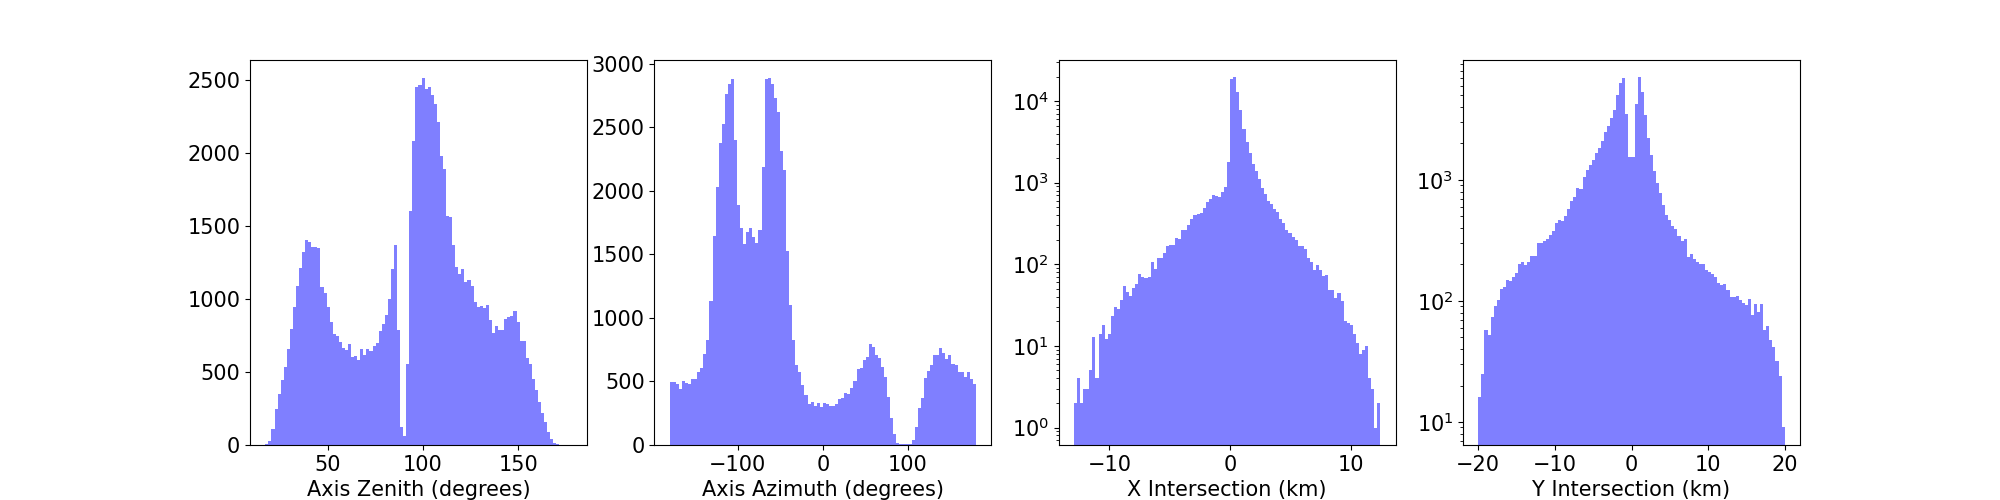

In [21]:

# Make a cut on the total camera plane distance from the camera
Distance = np.sqrt(All_X_Intersections**2 + All_Y_Intersections**2 + All_Z_Intersections**2)
Mask = Distance < 20

All_SDP_Thetas    = All_SDP_Thetas[Mask]
All_SDP_Phis      = All_SDP_Phis[Mask]
ALL_Chi0s         = ALL_Chi0s[Mask]
All_Rps           = All_Rps[Mask]
All_Axis_Zeniths    = All_Axis_Zeniths[Mask]
All_Axis_Azimuths   = All_Axis_Azimuths[Mask]
All_X_Intersections = All_X_Intersections[Mask]
All_Y_Intersections = All_Y_Intersections[Mask]
All_Z_Intersections = All_Z_Intersections[Mask]
All_Tel_IDs = All_Tel_IDs[Mask]


# Now we plot the results
fig, ax = plt.subplots(1, 4, figsize = (20,5))
# Plot the Axis Zeniths
ax[0].hist(All_Axis_Zeniths * 180 / np.pi, bins=100, color='blue', alpha=0.5)
ax[0].set_xlabel('Axis Zenith (degrees)')

# Plot the Axis Azimuths
ax[1].hist(All_Axis_Azimuths * 180 / np.pi, bins=100, color='blue', alpha=0.5)
ax[1].set_xlabel('Axis Azimuth (degrees)')

# Plot the X Intersections
ax[2].hist(All_X_Intersections, bins=100, color='blue', alpha=0.5)
ax[2].set_xlabel('X Intersection (km)')
ax[2].set_yscale('log')

# Plot the Y Intersections
ax[3].hist(All_Y_Intersections, bins=100, color='blue', alpha=0.5)
ax[3].set_xlabel('Y Intersection (km)')
ax[3].set_yscale('log')

Text(0, 0.5, 'Axis Zenith (degrees)')

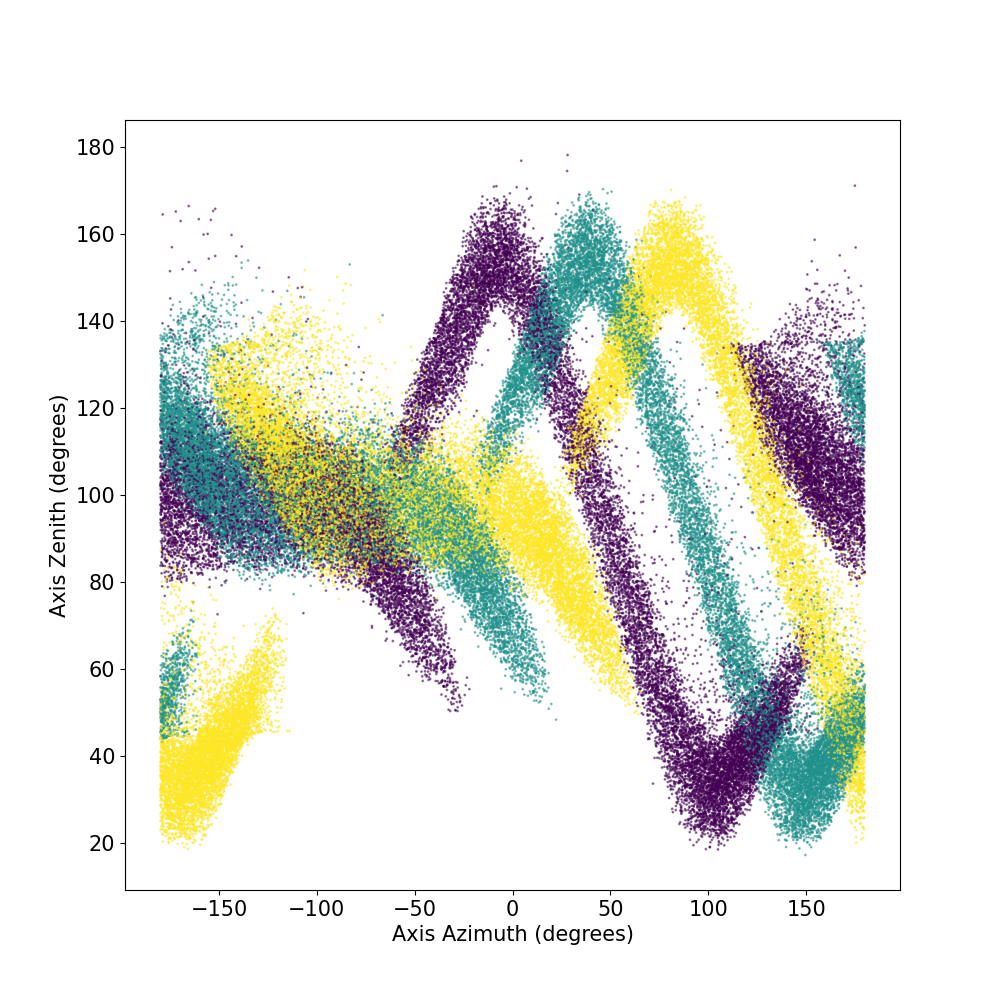

In [ ]:
X = All_SDP_Phis     * 180 / np.pi
Y = All_Axis_Zeniths * 180 / np.pi

X_label = 'Axis Azimuth (degrees)'
Y_label = 'Axis Zenith (degrees)'

plt.figure(figsize = [10,10])
plt.scatter(X,Y,s=1,c=All_Tel_IDs,alpha=0.5,cmap='viridis')
plt.xlabel(X_label)
plt.ylabel(Y_label)

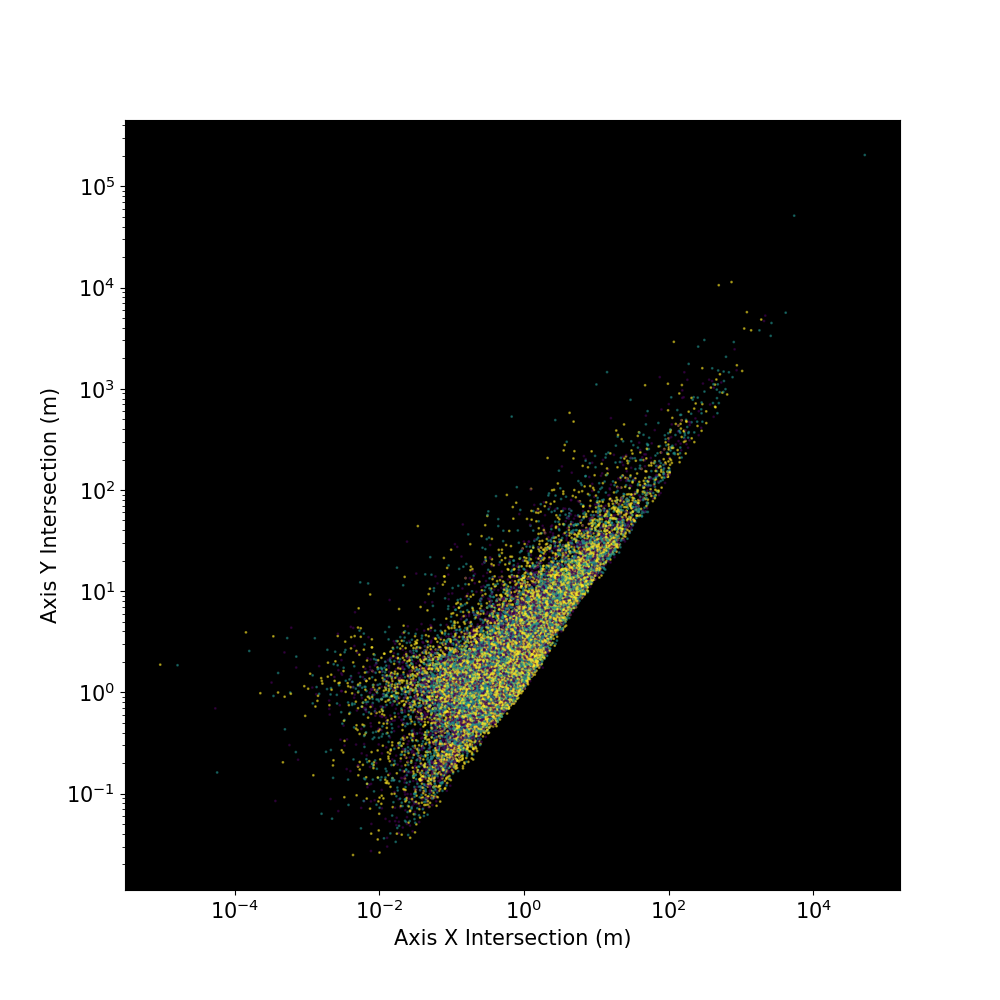

In [16]:
# Now we plot the results

X = All_X_Intersections
Y = All_Y_Intersections

X_label = 'Axis X Intersection (m)'
Y_label = 'Axis Y Intersection (m)'

plt.figure(figsize = [10,10])
plt.scatter(X,Y,s=1,c=All_Tel_IDs,alpha=0.5,cmap='viridis')
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.yscale('log')
plt.xscale('log')
plt.gca().set_facecolor('black')

Text(0.5, 0, 'Axis Angle (degrees)')

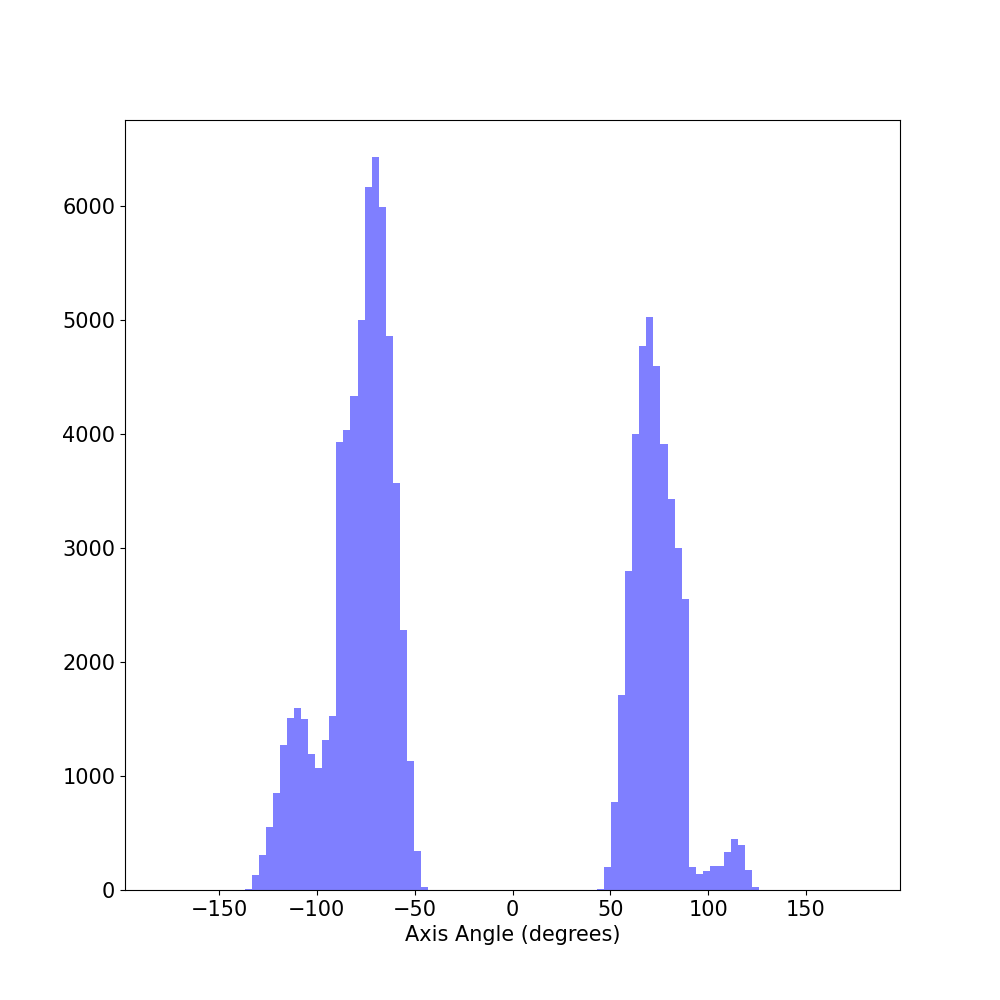

In [17]:
# make the direction out of X and Y
Angle = np.arctan2(All_Y_Intersections, All_X_Intersections)
Angle = Angle * 180 / np.pi

plt.figure(figsize = [10,10])
plt.hist(Angle,bins=100,range=(-180,180),color='blue',alpha=0.5)
plt.xlabel('Axis Angle (degrees)')

2.473475277463583
16.320012162723124
32.68842869263701
168.89934565724653


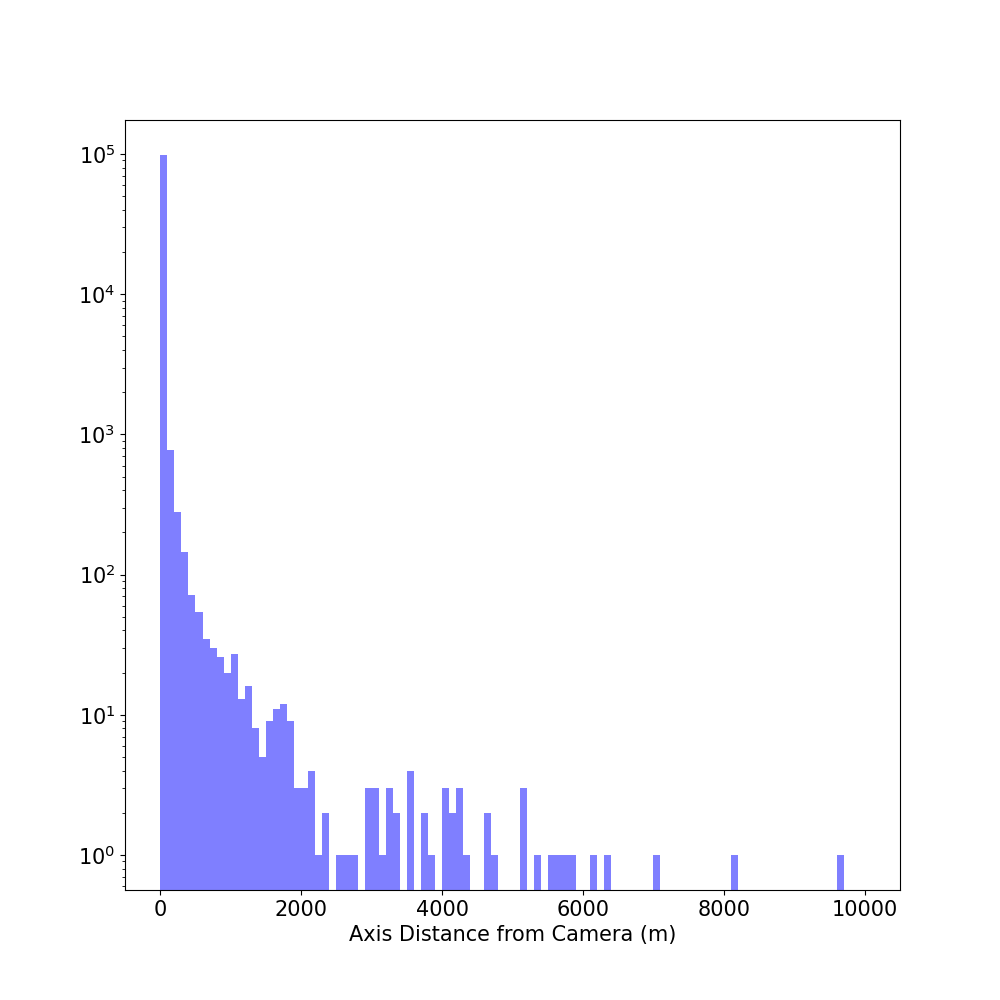

In [20]:
Distance = np.sqrt(All_X_Intersections**2 + All_Y_Intersections**2)
plt.figure(figsize = [10,10])
plt.hist(Distance,bins=100,range=(0,10000),color='blue',alpha=0.5)
plt.xlabel('Axis Distance from Camera (m)')
plt.yscale('log')

print(np.percentile(Distance, 50))
print(np.percentile(Distance, 90))
print(np.percentile(Distance, 95))
print(np.percentile(Distance, 99))

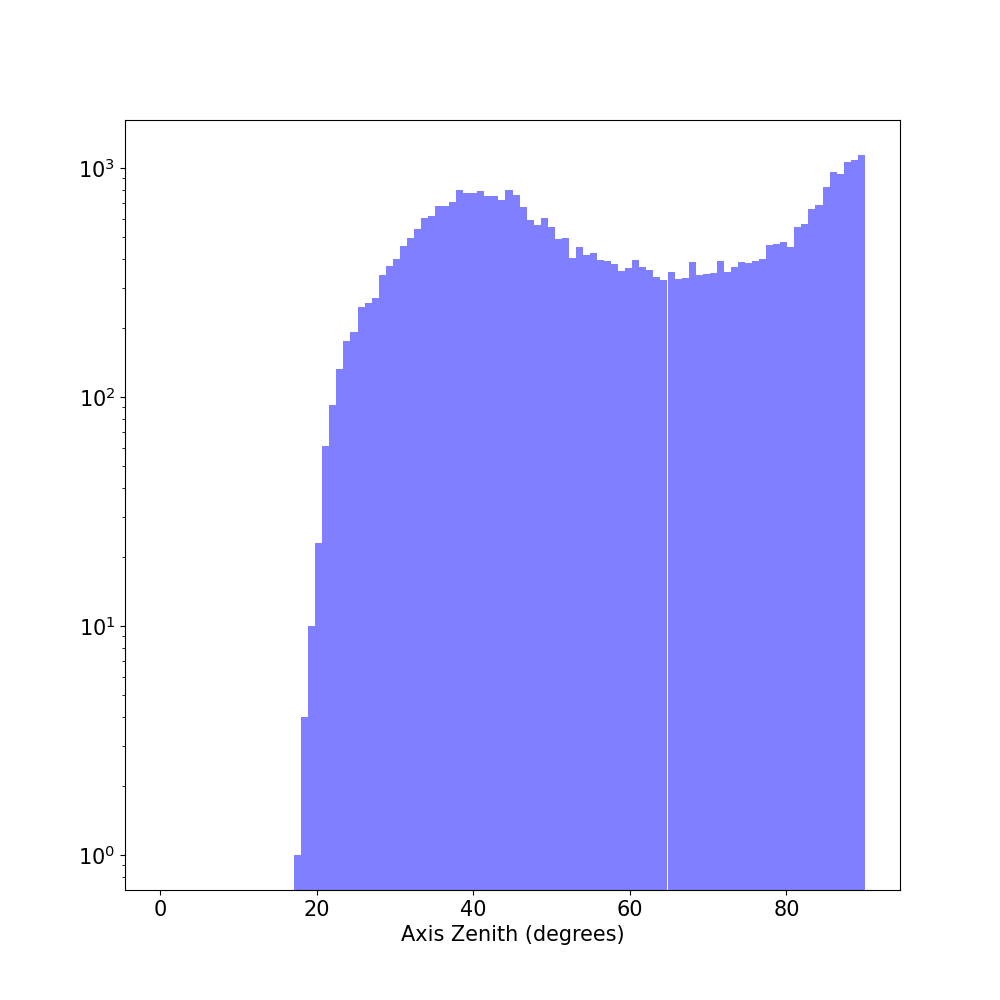

In [19]:
plt.figure(figsize = [10,10])
plt.hist(All_Axis_Zeniths * 180 / np.pi, bins=100, range=(0, 90), color='blue', alpha=0.5)
plt.xlabel('Axis Zenith (degrees)')
plt.yscale('log')